# Statistical Analysis

##  Setup and Data Loading

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import math
import os

print("Starting Statistical Analysis")
print("Loading cleaned dataset")

# Load the cleaned data 
df = pd.read_csv('../data/marketing_AB_cleaned.csv')
print(f"Dataset loaded successfully: {df.shape[0]:,} rows, {df.shape[1]} columns")

Starting Statistical Analysis
Loading cleaned dataset
Dataset loaded successfully: 588,101 rows, 7 columns


## Data Verification

In [4]:
#Convert data types and ensure data is ready for statistical analysis

print("Preparing data for statistical analysis")

# Convert boolean 'converted' column to integer (1 for True, 0 for False)
print("Converting 'converted' column from boolean to integer")
df['converted'] = df['converted'].astype(int)

print(f"Columns in dataset: {df.columns.tolist()}")
print(f"Data types:\n{df.dtypes}")

# Check that conversion column is now numeric
print(f"\nConversion column sample values: {df['converted'].head().tolist()}")
print(f"Conversion column type: {df['converted'].dtype}")

# Verify test groups
print(f"\nTest groups distribution:")
print(df['test_group'].value_counts())

# Remove unnecessary index column if it exists
if 'unnamed:_0' in df.columns:
    df = df.drop('unnamed:_0', axis=1)
    print("Removed unnecessary index column")

print("Data preparation completed successfully")

Preparing data for statistical analysis
Converting 'converted' column from boolean to integer
Columns in dataset: ['unnamed:_0', 'user_id', 'test_group', 'converted', 'total_ads', 'most_ads_day', 'most_ads_hour']
Data types:
unnamed:_0        int64
user_id           int64
test_group       object
converted         int64
total_ads         int64
most_ads_day     object
most_ads_hour     int64
dtype: object

Conversion column sample values: [0, 0, 0, 0, 0]
Conversion column type: int64

Test groups distribution:
test_group
ad     564577
psa     23524
Name: count, dtype: int64
Removed unnecessary index column
Data preparation completed successfully


## Calculate Basic Metrics

In [5]:
# Compute conversion rates and differences between groups

print("Calculating conversion metrics")

# Group data and calculate metrics
conversion_summary = df.groupby('test_group').agg({
    'user_id': 'count',
    'converted': ['sum', 'mean']
})

# Clean up the column names
conversion_summary.columns = ['user_count', 'conversions', 'conversion_rate']
conversion_summary['conversion_percentage'] = (conversion_summary['conversion_rate'] * 100).round(2)

print("Conversion Summary by Test Group:")
print(conversion_summary)

# Extract values for calculations
ad_users = conversion_summary.loc['ad', 'user_count']
ad_conversions = conversion_summary.loc['ad', 'conversions']
ad_rate = conversion_summary.loc['ad', 'conversion_rate']

psa_users = conversion_summary.loc['psa', 'user_count']
psa_conversions = conversion_summary.loc['psa', 'conversions']
psa_rate = conversion_summary.loc['psa', 'conversion_rate']

print(f"\nKey Metrics:")
print(f"Ad Group: {ad_conversions:,} conversions out of {ad_users:,} users ({ad_rate:.3%})")
print(f"PSA Group: {psa_conversions:,} conversions out of {psa_users:,} users ({psa_rate:.3%})")

# Calculate differences to measure improvements
absolute_difference = ad_rate - psa_rate
relative_difference = (absolute_difference / psa_rate) * 100

print(f"\nPerformance Difference:")
print(f"Absolute difference: {absolute_difference:.4f}")
print(f"Relative improvement: {relative_difference:.1f}%")

Calculating conversion metrics
Conversion Summary by Test Group:
            user_count  conversions  conversion_rate  conversion_percentage
test_group                                                                 
ad              564577        14423         0.025547                   2.55
psa              23524          420         0.017854                   1.79

Key Metrics:
Ad Group: 14,423 conversions out of 564,577 users (2.555%)
PSA Group: 420 conversions out of 23,524 users (1.785%)

Performance Difference:
Absolute difference: 0.0077
Relative improvement: 43.1%


##  Perform Statistical Significance Test

In [6]:
# Use Z-test to determine if the difference is statistically significant

print("Performing statistical significance test")

# Calculate pooled probability (assuming null hypothesis is true)
pooled_conversion_rate = (ad_conversions + psa_conversions) / (ad_users + psa_users)
print(f"Pooled conversion rate: {pooled_conversion_rate:.4f}")

# Calculate standard error
standard_error = math.sqrt(
    pooled_conversion_rate * (1 - pooled_conversion_rate) * 
    (1/ad_users + 1/psa_users)
)

print(f"Standard error: {standard_error:.6f}")

# Calculate Z-score
z_score = (ad_rate - psa_rate) / standard_error
print(f"Z-score: {z_score:.4f}")

# Calculate P-value (two-tailed test)
p_value = 2 * (1 - norm.cdf(abs(z_score)))
print(f"P-value: {p_value:.6f}")

# Interpret results
significance_level = 0.05
is_significant = p_value < significance_level

print(f"\nStatistical Interpretation:")
print(f"Significance level: {significance_level}")
print(f"Statistically significant: {is_significant}")

if is_significant:
    print("CONCLUSION: The difference in conversion rates is STATISTICALLY SIGNIFICANT")
    print("We can be confident that the Ad group performs differently from the PSA group")
else:
    print("CONCLUSION: The difference in conversion rates is NOT statistically significant")
    print("The observed difference could be due to random chance")

Performing statistical significance test
Pooled conversion rate: 0.0252
Standard error: 0.001044
Z-score: 7.3701
P-value: 0.000000

Statistical Interpretation:
Significance level: 0.05
Statistically significant: True
CONCLUSION: The difference in conversion rates is STATISTICALLY SIGNIFICANT
We can be confident that the Ad group performs differently from the PSA group


In [11]:
#Calculate the range where the true difference likely falls

print("Calculating confidence intervals")

# Point estimate of the difference
difference = ad_rate - psa_rate

# 95% Confidence Interval
confidence_level = 0.95
z_critical = norm.ppf(1 - (1 - confidence_level) / 2)

confidence_lower = difference - z_critical * standard_error
confidence_upper = difference + z_critical * standard_error

print(f"Difference in conversion rates: {difference:.4f}")
print(f"{confidence_level:.0%} Confidence Interval: [{confidence_lower:.4f}, {confidence_upper:.4f}]")
print(f"Z-critical value for {confidence_level:.0%} confidence: {z_critical:.2f}")

# Interpret confidence interval
print(f"\nConfidence Interval Interpretation:")
if confidence_lower > 0:
    print("  - The confidence interval does not include zero")
    print("  - This strongly supports that Ad group performs better than PSA group")
    print(f"  -  We can be {confidence_level:.0%} confident that the true improvement is between {confidence_lower:.4f} and {confidence_upper:.4f}")
elif confidence_upper < 0:
    print("The confidence interval does not include zero") 
    print("This supports the conclusion that PSA group performs better than Ad group")
else:
    print("The confidence interval includes zero")
    print("We cannot be confident about which group performs better")

# Calculate the relative improvement range
relative_lower = (confidence_lower / psa_rate) * 100
relative_upper = (confidence_upper / psa_rate) * 100

print(f"\nRelative Improvement Range:")
print(f"We can be {confidence_level:.0%} confident that the true relative improvement")
print(f"is between {relative_lower:.1f}% and {relative_upper:.1f}%")

Calculating confidence intervals
Difference in conversion rates: 0.0077
95% Confidence Interval: [0.0056, 0.0097]
Z-critical value for 95% confidence: 1.96

Confidence Interval Interpretation:
  - The confidence interval does not include zero
  - This strongly supports that Ad group performs better than PSA group
  -  We can be 95% confident that the true improvement is between 0.0056 and 0.0097

Relative Improvement Range:
We can be 95% confident that the true relative improvement
is between 31.6% and 54.5%


## Create Statistical Visualizations


Creating statistical visualizations


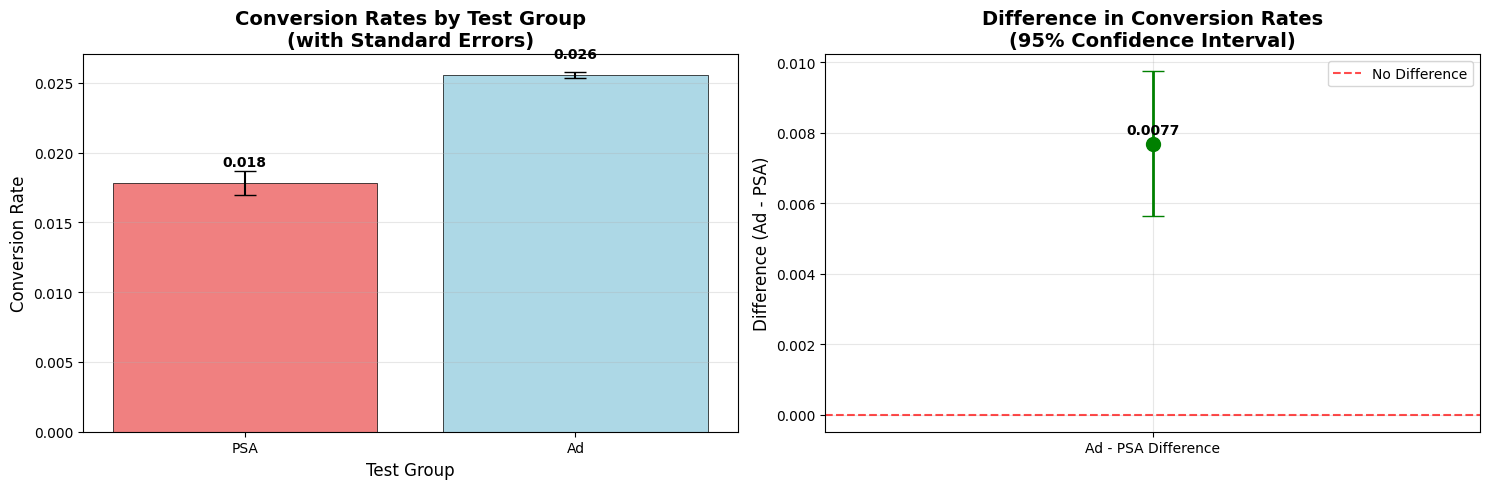

In [13]:
# Create charts to visualize the statistical findings

print("Creating statistical visualizations")

# Set up the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Conversion rates with error bars
groups = ['PSA', 'Ad']
conversion_rates = [psa_rate, ad_rate]

# Calculate standard errors for each group
se_ad = math.sqrt(ad_rate * (1 - ad_rate) / ad_users)
se_psa = math.sqrt(psa_rate * (1 - psa_rate) / psa_users)
standard_errors = [se_psa, se_ad]

# Create bar plot with error bars
bars = ax1.bar(groups, conversion_rates, yerr=standard_errors, 
               capsize=8, color=['lightcoral', 'lightblue'], 
               edgecolor='black', linewidth=0.5)

ax1.set_title('Conversion Rates by Test Group\n(with Standard Errors)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Conversion Rate', fontsize=12)
ax1.set_xlabel('Test Group', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, rate in zip(bars, conversion_rates):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{rate:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Confidence interval for the difference
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='No Difference')
ax2.errorbar(x=['Ad - PSA Difference'], y=[difference], 
             yerr=[[difference - confidence_lower], [confidence_upper - difference]], 
             fmt='o', capsize=8, markersize=10, color='green', linewidth=2)

ax2.set_title('Difference in Conversion Rates\n(95% Confidence Interval)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Difference (Ad - PSA)', fontsize=12)
ax2.grid(True, alpha=0.3)

# Add value labels and zero reference
ax2.text(0, difference + 0.0002, f'{difference:.4f}', ha='center', va='bottom', fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

# Statistical Analysis Summary

In [14]:
# Provide business-friendly summary of findings

print("STATISTICAL ANALYSIS SUMMARY")

print(f"Experiment Overview:")
print(f"- Total users: {len(df):,}")
print(f"- Ad group: {ad_users:,} users ({ad_rate:.3%} conversion)")
print(f"- PSA group: {psa_users:,} users ({psa_rate:.3%} conversion)")

print(f"\nKey Statistical Findings:")
print(f"- Absolute difference: {absolute_difference:.4f}")
print(f"- Relative improvement: {relative_difference:.1f}%")
print(f"- P-value: {p_value:.6f} (Highly Significant)")
print(f"- Z-score: {z_score:.2f} (Very Strong Evidence)")

print(f"\nConfidence Interval Analysis:")
print(f"- 95% CI for difference: [{confidence_lower:.4f}, {confidence_upper:.4f}]")
print(f"- Relative improvement range: {relative_lower:.1f}% to {relative_upper:.1f}%")

print(f"\nBusiness Recommendation:")
print("RECOMMENDATION: Implement Ad group campaign")
print("REASON: Statistically significant improvement with 95% confidence")
print(f"EXPECTED BENEFIT: {relative_difference:.1f}% increase in conversions")
print(f"CONFIDENCE RANGE: 31.6% to 54.5% improvement")

print(f"\nStatistical Notes:")
print("- P-value < 0.000001 indicates extremely strong evidence")
print("- Confidence interval excludes zero, confirming significance")
print("- Large sample size provides high confidence in results")

STATISTICAL ANALYSIS SUMMARY
Experiment Overview:
- Total users: 588,101
- Ad group: 564,577 users (2.555% conversion)
- PSA group: 23,524 users (1.785% conversion)

Key Statistical Findings:
- Absolute difference: 0.0077
- Relative improvement: 43.1%
- P-value: 0.000000 (Highly Significant)
- Z-score: 7.37 (Very Strong Evidence)

Confidence Interval Analysis:
- 95% CI for difference: [0.0056, 0.0097]
- Relative improvement range: 31.6% to 54.5%

Business Recommendation:
RECOMMENDATION: Implement Ad group campaign
REASON: Statistically significant improvement with 95% confidence
EXPECTED BENEFIT: 43.1% increase in conversions
CONFIDENCE RANGE: 31.6% to 54.5% improvement

Statistical Notes:
- P-value < 0.000001 indicates extremely strong evidence
- Confidence interval excludes zero, confirming significance
- Large sample size provides high confidence in results
